In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fbprophet import Prophet

In [3]:
train = pd.read_csv('./Data/dengue_features_train.csv', encoding='utf-8')
test = pd.read_csv('./Data/dengue_features_test.csv', encoding='utf-8')
labels = pd.read_csv('./Data/dengue_labels_train.csv', encoding='utf-8')

In [4]:
train.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [5]:
train['total_cases'] = labels['total_cases']
prophet_data = train[['city', 'week_start_date', 'total_cases']]

In [6]:
prophet_data.head()

,city,week_start_date,total_cases
0,sj,1990-04-30,4
1,sj,1990-05-07,5
2,sj,1990-05-14,4
3,sj,1990-05-21,3
4,sj,1990-05-28,6


In [7]:
prophet_data_sj = prophet_data[prophet_data['city'] == 'sj'].drop('city', axis=1)

prophet_data_iq = prophet_data[prophet_data['city'] == 'iq'].drop('city', axis=1)

In [8]:
prophet_data_sj.head()

,week_start_date,total_cases
0,1990-04-30,4
1,1990-05-07,5
2,1990-05-14,4
3,1990-05-21,3
4,1990-05-28,6


In [9]:
test_sj = test[test['city'] == 'sj']['week_start_date']
test_iq = test[test['city'] == 'iq']['week_start_date']

In [10]:
test_sj.head()

0    2008-04-29
1    2008-05-06
2    2008-05-13
3    2008-05-20
4    2008-05-27
Name: week_start_date, dtype: object

In [11]:
prophet_data_sj.columns, prophet_data_iq.columns = ['ds', 'y'], ['ds', 'y']

In [12]:
def create_forecast(train_data, test_data, flex, seas):
    
    prophet = Prophet(changepoint_prior_scale=flex,yearly_seasonality=seas) 
    
    prophet.fit(train_data)
    
    future_frame = prophet.make_future_dataframe(
        periods=len(test_data), 
        freq='W')
    
    forecast = prophet.predict(future_frame)
    prophet.plot(forecast)
    forecast = forecast[['ds', 'yhat']].yhat.apply(lambda x : int(x))
    
    return forecast[len(train_data):]

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


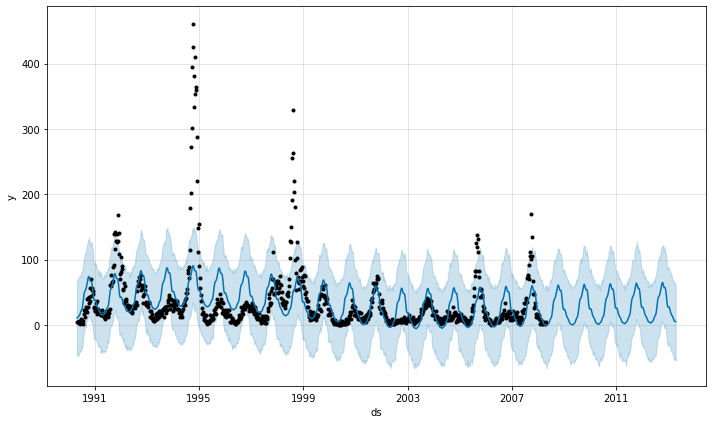

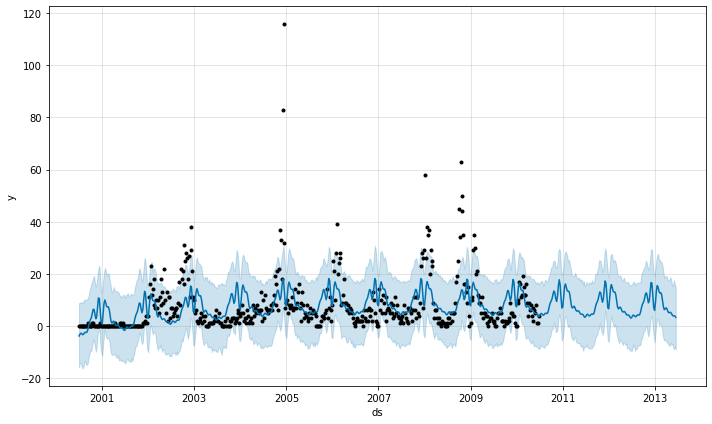

In [13]:
forecast_sj = create_forecast(prophet_data_sj, test_sj, 0.05, 10)
forecast_iq = create_forecast(prophet_data_iq, test_iq, 0.05, 10)

In [14]:
def create_submission(forecast_sj, forecast_iq, sub_name):
    
    test_index = test[['city', 'year', 'weekofyear']]
    
    output = pd.concat([forecast_sj, forecast_iq])\
        .reset_index().drop(['index'], axis=1)
        
    output.columns = ['total_cases']
    
    pd.concat([test_index, output], axis=1)\
        .set_index(['city']).to_csv(sub_name + '.csv')

In [16]:
create_submission(forecast_sj, forecast_iq, 'AG02_V2_prophet')